In [1]:
%matplotlib inline
import os
import ants
import numpy as np
import time
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

from glom_pop import dataio, alignment


#                   (Time series, associated anatomical z series for this fly)
brain_file_sets = [('TSeries-20210804-001', 'ZSeries-20210804-001'),
                   ('TSeries-20210804-002', 'ZSeries-20210804-001'),
                   ('TSeries-20210804-004', 'ZSeries-20210804-004'),
                   ('TSeries-20210804-005', 'ZSeries-20210804-004'),
                   ('TSeries-20210804-007', 'ZSeries-20210804-007'),
                   ('TSeries-20210804-008', 'ZSeries-20210804-007'),
                   ]

meanbrain_fn = 'chat_meanbrain_{}.nii'.format('20210805')

data_dir = '/oak/stanford/groups/trc/data/Max/ImagingData/Bruker'
base_dir = '/oak/stanford/groups/trc/data/Max/Analysis/glom_pop'

In [2]:
# Load master meanbrain
reference_fn = 'ZSeries-20210804-001'
metadata = dataio.get_bruker_metadata(os.path.join(base_dir, 'anatomical_brains', reference_fn) + '.xml')
meanbrain_red = dataio.get_ants_brain(os.path.join(base_dir, 'mean_brains', meanbrain_fn), metadata, channel=0)

# Load glom map, in meanbrain space
mask_fp = os.path.join(base_dir, 'aligned', 'glom_mask_reg2meanbrain.nii')
glom_mask_2_meanbrain = np.asanyarray(nib.load(mask_fp).dataobj).astype('uint32')
# Load mask key for VPN types
vpn_types = pd.read_csv(os.path.join(base_dir, 'template_brain', 'vpn_types.csv'))
# Filter glom map s.t. only big gloms are included
glom_size_threshold = 300
glom_mask_2_meanbrain = alignment.filterGlomMask(glom_mask_2_meanbrain, glom_size_threshold)
vals = np.unique(glom_mask_2_meanbrain)[1:]  # exclude first val (=0, not a glom)
names = vpn_types.loc[vpn_types.get('Unnamed: 0').isin(vals), 'vpn_types']

# convert to ants image
glom_mask_2_meanbrain = ants.from_numpy(glom_mask_2_meanbrain, spacing=meanbrain_red.spacing)

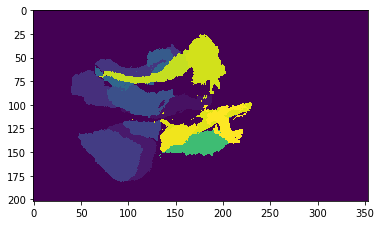

In [3]:
plt.imshow(glom_mask_2_meanbrain.max(axis=2).T)

In [4]:
bf = brain_file_sets[0]

In [5]:
functional_fn = bf[0]
anatomical_fn = bf[1]

date_str = functional_fn.split('-')[1]

# # # Load anatomical scan # # #
anat_filepath = os.path.join(data_dir, date_str, anatomical_fn)
metadata = dataio.get_bruker_metadata(anat_filepath + '.xml')
red_brain = dataio.get_ants_brain(anat_filepath + '_channel_1.nii', metadata)  # xyz

# # # Compute transform from ANAT -> MEANBRAIN # # #
reg_AM = ants.registration(meanbrain_red,
                           red_brain,
                           type_of_transform='SyN',
                           flow_sigma=3,
                           total_sigma=0)

# # # Apply inverse transform to glom mask # # #
glom_mask_2_anat = ants.apply_transforms(fixed=red_brain,
                                         moving=glom_mask_2_meanbrain,
                                         transformlist=reg_AM['invtransforms'],
                                         interpolator='nearestNeighbor',
                                         defaultvalue=0)


In [6]:
glom_mask_2_anat

ANTsImage (RAI)
	 Pixel Type : unsigned int (uint32)
	 Components : 1
	 Dimensions : (354, 202, 45)
	 Spacing    : (0.5002, 0.5002, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

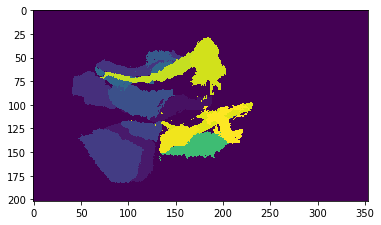

In [7]:
plt.imshow(glom_mask_2_anat.max(axis=2).T)

In [8]:
# # # Compute transform from FXN -> ANAT # # #
fxn_filepath = os.path.join(data_dir, date_str, functional_fn)
metadata_fxn = dataio.get_bruker_metadata(fxn_filepath + '.xml')
fxn_red = dataio.get_time_averaged_brain(dataio.get_ants_brain(fxn_filepath + '_reg.nii', metadata_fxn, channel=0))  # xyz
reg_FA = ants.registration(red_brain,
                           fxn_red,
                           type_of_transform='SyN',
                           flow_sigma=3,
                           total_sigma=0)


# # # Apply inverse transform to glom mask # # #
glom_mask_2_fxn = ants.apply_transforms(fixed=fxn_red,
                                        moving=glom_mask_2_anat,
                                        transformlist=reg_FA['invtransforms'],
                                        interpolator='nearestNeighbor',
                                        defaultvalue=0)

In [9]:
glom_mask_2_fxn

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (177, 101, 12)
	 Spacing    : (1.0004, 1.0004, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

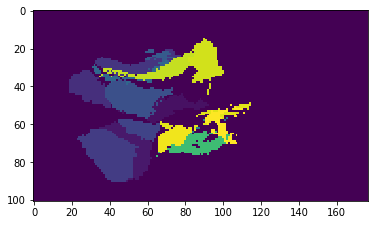

In [10]:
plt.imshow(glom_mask_2_fxn.max(axis=2).T)

In [11]:
# Load functional (green) brain series
green_brain = dataio.get_ants_brain(fxn_filepath + '_reg.nii', metadata_fxn, channel=1)  # xyzt

In [12]:
glom_responses = alignment.getGlomResponses(green_brain,
                                            glom_mask_2_fxn.numpy(),
                                            mask_values=None)

In [14]:
glom_mask_2_fxn.shape

(177, 101, 12)

In [13]:
glom_responses.shape

(17, 7039)

In [ ]:
 # ATTACH: meanbrain, glom mask, responses, key/names

In [16]:
np.unique(glom_mask_2_fxn.numpy())

array([ 0.,  2.,  3.,  6.,  7.,  8.,  9., 11., 13., 15., 20., 31., 41.,
       42., 43., 44., 45.], dtype=float32)

In [19]:
vals

array([ 2,  3,  6,  7,  8,  9, 11, 13, 15, 20, 31, 41, 42, 43, 44, 45],
      dtype=uint32)